# Required Libraries

In [14]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

from pprint import pprint
import numpy as np

# Dataset
Load the dataset and print the classes

In [15]:
# Load the Reuters dataset
newsgroups_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

classes = list(newsgroups_train.target_names)
pprint(classes)

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


Let's see the first example. It's a letter form.

In [16]:
print("SHAPE ", newsgroups_train.filenames.shape)
print("----------------------------------------")
print(newsgroups_train.data[0])
print("----------------------------------------")
print(newsgroups_train.target[0], "=>", classes[newsgroups_train.target[0]])

SHAPE  (11314,)
----------------------------------------
I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.
----------------------------------------
7 => rec.autos


# Preprocessing

Preprocessiamo ogni esempio del training. Rimuoviamo le parole "stopwords" e calcoliamo la rappresentazione vettoriale tf-idf.

La rappresentazione della matrice è sparsa: viene mostrato un elenco di celle non nulle.
(riga, colonna) valore

Ad esempio
(0, 59071)	0.10043853867312116 

In particolare, significano:
(numero frase, indice della parola nel dizionario)  valore tf-idf

Se provi a cercare un indice non elencato nella lista, otterrai valore 0.0

In [17]:
# Extract features from the dataset - traduciamo le parole in vettori.
vectorizer = TfidfVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(newsgroups_train.data) # impara dal training set la matrice SPARSA tf-idf
X_test = vectorizer.transform(newsgroups_test.data) # riutilizza la tf-idf per assegnarla alle parole nel testing set
y_train = newsgroups_train.target
y_test = newsgroups_test.target

# len(vectorizer.get_feature_names_out())

Let's see what's inside after the transformation

In [18]:
print(X_train[0])
print(X_train.shape)
print(len(newsgroups_train.data), len(vectorizer.vocabulary_))

  (0, 59071)	0.10043853867312116
  (0, 57250)	0.1063473585616558
  (0, 41874)	0.224548896412017
  (0, 49800)	0.11869932893481257
  (0, 46690)	0.12504220873599214
  (0, 73174)	0.16142029533900565
  (0, 99608)	0.09418459052541318
  (0, 84050)	0.16329311028814825
  (0, 37208)	0.1434127293323407
  (0, 62594)	0.13037295035007848
  (0, 87913)	0.25808578247347563
  (0, 54493)	0.06961997844491917
  (0, 23430)	0.12937103288512333
  (0, 77676)	0.12197186951739486
  (0, 81450)	0.1461308934288897
  (0, 24583)	0.19644480500804062
  (0, 16806)	0.1407774554706102
  (0, 83208)	0.11339406589538423
  (0, 76269)	0.08978258481915573
  (0, 34742)	0.17300821242559045
  (0, 24108)	0.24723134514216435
  (0, 25437)	0.10548299054214269
  (0, 11174)	0.20599311323287353
  (0, 35902)	0.1266709604197344
  (0, 9843)	0.20797700857530224
  (0, 55606)	0.13822596989753821
  (0, 57247)	0.1352084247105906
  (0, 84312)	0.16368392505928514
  (0, 34741)	0.14847880131844235
  (0, 31927)	0.10526008886822914
  (0, 80420)	0.1270

Each dimension corresponds to a word in the original text. For example:

In [19]:
indice_parola = 59071
# sono in ordine alfabetico
print(vectorizer.get_feature_names_out()[indice_parola], X_train[0, indice_parola])
print(vectorizer.get_feature_names_out()[indice_parola+1], X_train[0, indice_parola+1])
print(vectorizer.get_feature_names_out()[indice_parola+2], X_train[0, indice_parola+2])

mail 0.10043853867312116
mail_________________________________ 0.0
mail_address 0.0


# Term frequency - inverse document frequency fatta a mano

$$tf_{i,j} = \frac{n_{i,j}} {|d_j|}$$
$$n_{i,j} = \text{numero di volte in cui compare la parola nel documento}$$
$$|d_j|={\text{numero di parole del documento}}$$
-----
$$ idf_w = log_{10} \frac{|D|}{|\{d: w \in d\}|} $$
$$ |D| = \text{numero dei documenti nel corpus} $$
$$ |\{d: w \in d\}| = \text{numero di documenti in cui la parola w appare} $$
$$\text{tf-idf} = tf_{i,j} \cdot idf_i$$
---

In [16]:
import math

documento1 = "Giacomo Ciao"
documento2 = "Ciao Learning Machine"
documento3 = "Giacomo Giacomo Learning"
corpus = [documento1, documento2, documento3]


def numero_occorrenze_in_doc(parola, documento):
    n_ij = 0
    for parola_doc in documento.split(" "):
        if parola_doc == parola:
            n_ij += 1
    return n_ij

def numero_parole_documento(documento):
    return len(documento.split(" "))

def numero_documenti_con_parola(corpus, parola):
    Dw = 0
    for documento in corpus:
        if parola in documento.split(" "):
            Dw += 1
    return Dw
def numero_documenti_corpus(corpus):
    return len(corpus)

def term_frequency(parola, documento):
    return numero_occorrenze_in_doc(parola, documento) / numero_parole_documento(documento)

def inverse_document_frequency(parola, corpus):
    if (numero_documenti_con_parola(corpus, parola) == 0):
        return 0
    return math.log(numero_documenti_corpus(corpus) / numero_documenti_con_parola(corpus, parola) , 10)

def tf_idf(parola, documento, corpus):
    return term_frequency(parola, documento) * inverse_document_frequency(parola, corpus)

def vocabolario(corpus):
    dic = set()
    for documento in corpus:
        for parola in documento.split(" "):
            dic.add(parola)
    return dic

def vettore_tf_idf_documento(documento, corpus):
    vett = []
    voc = vocabolario(corpus)
    for parola in voc:
        tf_idf_parola_doc = tf_idf(parola, documento, corpus)
        vett.append((parola, tf_idf_parola_doc))
    return vett

# stampiamo il vettore tf-idf di ogni documento del corpus

for i,doc in enumerate(corpus):
    print(i, vettore_tf_idf_documento(doc, corpus))


0 [('Machine', 0.0), ('Giacomo', 0.08804562952784062), ('Ciao', 0.08804562952784062), ('Learning', 0.0)]
1 [('Machine', 0.15904041823988746), ('Giacomo', 0.0), ('Ciao', 0.058697086351893746), ('Learning', 0.058697086351893746)]
2 [('Machine', 0.0), ('Giacomo', 0.11739417270378749), ('Ciao', 0.0), ('Learning', 0.058697086351893746)]


In [30]:
vectorizer2 = TfidfVectorizer(stop_words='english')
documento1 = "Giacomo Ciao"
documento2 = "Ciao Learning Machine"
documento3 = "Giacomo Giacomo Learning"

x_train_prova = vectorizer2.fit_transform([documento1, documento2, documento3])
print(x_train_prova.asformat("array"))
print(vectorizer2.get_feature_names_out())

[[0.70710678 0.70710678 0.         0.        ]
 [0.51785612 0.         0.51785612 0.68091856]
 [0.         0.89442719 0.4472136  0.        ]]
['ciao' 'giacomo' 'learning' 'machine']


# Naive Bayes
Con Naive Bayes assumiamo una indipendenza forte tra le feature del modello. Ogni feature è condizionatamente indipendente dall'altra data una classe.

## Multinomial NB
Usato per feature discrete, come le parole in un testo.
Ogni frase è rappresentata da un vettore, con tanti elementi quanti sono i termini del dizionario, il cui il valore è il numero di occorrenze o il valore **tf-idf**.

In [21]:
# define the Multinomial Naive Bayes model
MultinomialNB_model = MultinomialNB(alpha=0.01) # problema di classificazione multi-classe. alpha= parametro di smoothing

# train
MultinomialNB_model.fit(X_train, y_train)

# predict
y_pred = MultinomialNB_model.predict(X_test[:500])
print(classification_report(y_test[:500], y_pred, target_names=classes))

                          precision    recall  f1-score   support

             alt.atheism       0.44      0.19      0.27        21
           comp.graphics       0.58      0.67      0.62        21
 comp.os.ms-windows.misc       0.65      0.50      0.57        26
comp.sys.ibm.pc.hardware       0.70      0.76      0.73        34
   comp.sys.mac.hardware       0.81      0.74      0.77        34
          comp.windows.x       0.83      0.73      0.78        26
            misc.forsale       0.74      0.77      0.76        22
               rec.autos       0.79      0.79      0.79        28
         rec.motorcycles       0.85      0.70      0.77        33
      rec.sport.baseball       1.00      0.88      0.94        25
        rec.sport.hockey       0.67      0.96      0.79        27
               sci.crypt       0.71      0.85      0.77        20
         sci.electronics       0.74      0.58      0.65        24
                 sci.med       0.75      0.91      0.82        23
         

We can extract for each class the most important features (words in our case) and print them.

In [22]:
# show the top 10 features
def show_top10(classifier: MultinomialNB, vectorizer: TfidfVectorizer, categories: list[str]):
  feature_names = np.asarray(vectorizer.get_feature_names_out()) # prende l'array di tutte le parole
  for i, category in enumerate(categories):
    top10 = np.argsort(classifier.feature_count_[i])[-10:] # prende l'elemento in posizione i tra i primi 10
    print("%30s: \t%s" % (category, " ".join(feature_names[top10])))

show_top10(MultinomialNB_model, vectorizer, classes)

                   alt.atheism: 	islam atheists say just religion atheism think don people god
                 comp.graphics: 	looking format 3d know program file files thanks image graphics
       comp.os.ms-windows.misc: 	card problem thanks driver drivers use files dos file windows
      comp.sys.ibm.pc.hardware: 	monitor disk thanks pc ide controller bus card scsi drive
         comp.sys.mac.hardware: 	know monitor does quadra simms thanks problem drive apple mac
                comp.windows.x: 	using windows x11r5 use application thanks widget server motif window
                  misc.forsale: 	asking email sell price condition new shipping offer 00 sale
                     rec.autos: 	don ford new good dealer just engine like cars car
               rec.motorcycles: 	don just helmet riding like motorcycle ride bikes dod bike
            rec.sport.baseball: 	braves players pitching hit runs games game baseball team year
              rec.sport.hockey: 	league year nhl games sea

## Multivariate NB

We can train a Bernoulli model, that is the Multivariate implementation of the NB.
Usato per le feature binarie (conta solo la presenza o l'assenza delle parole).

Un documento è rappresentato da un vettore con valori in {0,1} con dimensione pari al numero di parole del dizionario.

vocabolario = [Ciao, Giacomo, Machine, Learning]

frase = "Ciao Giacomo"

vettore_frase = [1, 1, 0, 0]


In [23]:
# define the Multivariate Naive Bayes model
BernoulliNB_model = BernoulliNB(alpha=.01)

# train
BernoulliNB_model.fit(X_train, y_train)

# predict
y_pred = BernoulliNB_model.predict(X_test[:500])
print(classification_report(y_test[:500], y_pred, target_names=classes))

                          precision    recall  f1-score   support

             alt.atheism       0.36      0.43      0.39        21
           comp.graphics       0.41      0.57      0.48        21
 comp.os.ms-windows.misc       0.00      0.00      0.00        26
comp.sys.ibm.pc.hardware       0.57      0.79      0.67        34
   comp.sys.mac.hardware       0.40      0.79      0.53        34
          comp.windows.x       0.75      0.46      0.57        26
            misc.forsale       0.77      0.77      0.77        22
               rec.autos       0.48      0.79      0.59        28
         rec.motorcycles       0.50      0.73      0.59        33
      rec.sport.baseball       0.79      0.88      0.83        25
        rec.sport.hockey       1.00      0.85      0.92        27
               sci.crypt       0.83      0.50      0.62        20
         sci.electronics       0.52      0.62      0.57        24
                 sci.med       0.84      0.70      0.76        23
         

/home/giaco/PycharmProjects/CodiceML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/giaco/PycharmProjects/CodiceML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/giaco/PycharmProjects/CodiceML/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

And then see the most important features for each class.

In [24]:
show_top10(BernoulliNB_model, vectorizer, classes)

                   alt.atheism: 	time know does god like say just think people don
                 comp.graphics: 	just don program need does use like know graphics thanks
       comp.os.ms-windows.misc: 	does dos like just file using thanks know use windows
      comp.sys.ibm.pc.hardware: 	pc problem use drive just like card does know thanks
         comp.sys.mac.hardware: 	problem don use like just thanks does apple know mac
                comp.windows.x: 	help server problem know does using like thanks use window
                  misc.forsale: 	mail used edu sell condition interested shipping offer new sale
                     rec.autos: 	time new think know good cars don just like car
               rec.motorcycles: 	time ride dod good think don know just like bike
            rec.sport.baseball: 	games time team good game don like just think year
              rec.sport.hockey: 	year good don think just like play hockey game team
                     sci.crypt: 	chip clipper g

# EXERCISE:
* (1) Find the best _alpha_ parameter for **MultinomialNB** and **BernoulliNB** models.
* (2) Plot the results taking _F1_ measure as reference.
* (3) Make a comparison between **Rocchio**, **MultinomialNB** and **BernoulliNB** model.


### Esercizio 1 - Miglior smoothing

In [62]:
from typing import List, Tuple
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import get_scorer_names, make_scorer
from sklearn.model_selection import cross_val_score

def find_best_alpha(model, start_alpha, stop_alpha, increment) -> Tuple[List[float], List[float], float, float]:
    alpha = best_alpha = start_alpha
    best_f1 = 0.00
    alphas = []
    f1s = []
    while alpha < stop_alpha:
        f1 = cross_val_score(estimator=model(alpha), X=X_train, y=y_train, cv=10, scoring='f1_micro')
        # the_model = model(alpha=alpha)
        # f1 macro = media aritmetica di tutti gli f1 (20)
        # f1 pesata = in base al peso di ogni classe
        # f1 micro = data dalla somma dei TP + FP + FN + TN
        f1_mean = f1.mean()
        alphas.append(alpha)
        f1s.append(f1_mean)
        if f1_mean > best_f1:
            best_f1 = f1_mean
            best_alpha = alpha

        
        alpha += increment

    print("best alpha", best_alpha,"best f1", best_f1)
    return alphas, f1s, best_alpha, best_f1


In [58]:
alphasMNB, f1sMNB, bestAlphaMNB, bestF1MNB = find_best_alpha(lambda a: MultinomialNB(alpha=a), 0.001, 0.06, 0.001)

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weight

In [63]:
alphasBNB, f1sBNB, bestAlphaBNB, bestF1BNB = find_best_alpha(lambda a: BernoulliNB(alpha=a), 3e-07, 3e-06, 2e-07)

best alpha 7e-07 best f1 0.6600709838068191


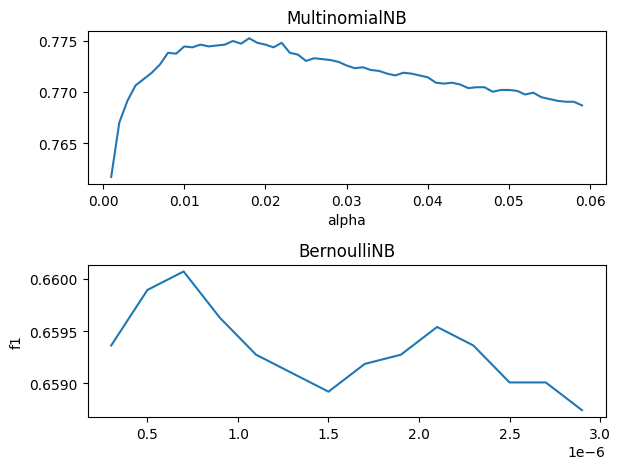

In [64]:
# plotting f1 vs alpha 

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(alphasMNB, f1sMNB)
ax1.set_title("MultinomialNB")
ax1.set_xlabel("alpha")
ax2.set_ylabel("f1")
ax2.plot(alphasBNB, f1sBNB)
ax2.set_title("BernoulliNB")
fig.tight_layout()